In [1]:
from deap import base, creator, tools, algorithms
from time import time
import random
import numpy
import matplotlib.pyplot as plt

In [2]:
maze = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0],
    [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
    [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
    [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
    [0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
]

s = {
    "x": 1,
    "y": 1
}

e = {
    "x": 10,
    "y": 10
}

In [3]:
def path(individual):
    # 0 - ↑ (W)
    # 1 - ← (A)
    # 2 - ↓ (S)
    # 3 - → (D)

    path = ""

    for move in individual:
        if move == 0:
            path += "↑ "
        elif move == 1:
            path += "← "
        elif move == 2:
            path += "↓ "
        elif move == 3:
            path += "→ "
    
    return path


def score(x, y, pathLength, individual):
    maxDistance = (len(maze) - 2) ** 2 + (len(maze[0]) - 2) ** 2
    distance = abs(e["x"] - x) ** 2 + abs(e["y"] - y) ** 2
    maxPathLength = (len(maze) - 2) * (len(maze[0]) - 2)

    if mutuallyExclusiveMoves(individual):
        return maxDistance - distance + maxPathLength - pathLength - 20
    else:
        return maxDistance - distance + maxPathLength - pathLength


def deadEnd(x, y):
    return maze[y - 1][x] + maze[y][x - 1] + maze[y + 1][x] + maze[y][x + 1] == 1


def mutuallyExclusiveMoves(individual):
    return str([0, 2])[1:-1] in str(individual) or str([2, 0])[1:-1] in str(individual) or str([1, 3])[1:-1] in str(individual) or str([3, 1])[1:-1] in str(individual)


def evaluate(individual):
    x, y = s["x"], s["y"]
    pathLength = 0

    for move in individual:
        if move == 0:
            y -= 1
        elif move == 1:
            x -= 1
        elif move == 2:
            y += 1
        elif move == 3:
            x += 1
        
        if maze[y][x]:
            pathLength += 1

            if deadEnd(x, y):
                return score(x, y, pathLength, individual) - 20,
            
            if x == e["x"] and y == e["y"]:
                return score(x, y, pathLength, individual),
        else:
            return score(x, y, pathLength, individual),
    
    return score(x, y, pathLength, individual),

In [4]:
print(path([3, 3, 2, 3, 3, 0, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2]))
print(evaluate([3, 3, 2, 3, 3, 0, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2]))

→ → ↓ → → ↑ → → ↓ ↓ ↓ ↓ ↓ → → ↓ → ↓ ↓ ↓ 
(280,)


In [5]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)


def withoutElitism(ind, pop, cxpb, mutpb, ngen):
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 3)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=ind)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=pop)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, halloffame=hof, verbose=True)

    return pop, logbook, hof


def withElitism(ind, pop, mu, lambda_, cxpb, mutpb, ngen):
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 3)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=ind)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=pop)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, halloffame=hof, verbose=True)

    return pop, logbook, hof

In [6]:
start = time()
pop, logWithoutElitism20, hof = withoutElitism(ind=20, pop=2000, cxpb=0.65, mutpb=0.15, ngen=30)
stop = time()
timeWithoutElitism20 = stop - start
print(timeWithoutElitism20)
print(path(*hof))

gen	nevals	avg    	min	max
0  	2000  	115.245	94 	195
1  	1443  	131.938	94 	195
2  	1390  	144.422	94 	195
3  	1340  	152.841	90 	211
4  	1407  	160.394	90 	211
5  	1395  	167.669	92 	215
6  	1463  	174.843	99 	217
7  	1442  	183.743	99 	215
8  	1420  	189.296	90 	225
9  	1369  	191.428	86 	225
10 	1437  	192.625	99 	225
11 	1378  	195.413	92 	249
12 	1424  	197.59 	92 	249
13 	1400  	201.131	92 	255
14 	1434  	202.607	88 	255
15 	1429  	203.296	88 	255
16 	1406  	202.593	92 	273
17 	1421  	202.993	88 	273
18 	1421  	204.776	88 	273
19 	1448  	207.2  	88 	277
20 	1393  	216.131	92 	277
21 	1427  	226.235	99 	277
22 	1377  	234.368	92 	277
23 	1406  	242.514	99 	279
24 	1438  	248.47 	99 	279
25 	1402  	254.66 	99 	279
26 	1417  	260.969	99 	279
27 	1416  	260.228	99 	280
28 	1402  	262.257	99 	280
29 	1444  	260.915	99 	280
30 	1401  	261.992	99 	280
3.5045166015625
→ → ↓ → → ↑ → → ↓ ↓ ↓ ↓ ↓ → → ↓ → ↓ ↓ ↓ 


In [7]:
start = time()
pop, logWithElitism20, hof = withElitism(ind=20, pop=2000, mu=200, lambda_=1800, cxpb=0.65, mutpb=0.15, ngen=30)
stop = time()
timewithElitism20 = stop - start
print(timewithElitism20)
print(path(*hof))

gen	nevals	avg    	min	max
0  	2000  	114.891	92 	191
1  	1404  	134.515	99 	191
2  	1425  	148.75 	99 	191
3  	1413  	158.44 	135	191
4  	1404  	167.43 	151	195
5  	1432  	180.71 	151	195
6  	1444  	189.1  	157	211
7  	1408  	191.9  	170	211
8  	1442  	193.78 	191	215
9  	1446  	195.58 	191	215
10 	1417  	198.655	191	215
11 	1449  	202.3  	191	215
12 	1431  	206.88 	195	215
13 	1459  	211.805	195	215
14 	1435  	214.045	195	215
15 	1465  	214.76 	195	215
16 	1414  	215    	215	215
17 	1428  	214.6  	195	215
18 	1436  	215    	215	215
19 	1441  	214.9  	195	215
20 	1421  	214.7  	195	215
21 	1459  	214.9  	195	215
22 	1439  	214.9  	195	215
23 	1438  	214.9  	195	215
24 	1432  	215    	215	215
25 	1420  	214.8  	195	215
26 	1446  	214.9  	195	215
27 	1454  	215    	215	215
28 	1444  	214.9  	195	215
29 	1488  	214.8  	195	215
30 	1452  	215    	215	215
4.004003047943115
→ → ↓ → → ↑ → → ↓ → → ↓ → ↓ ← ↓ → ↓ ← ← 


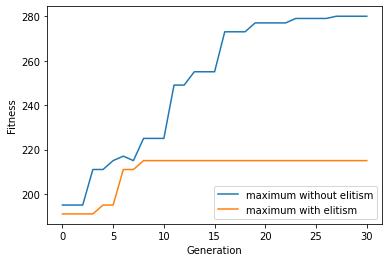

In [8]:
gen, maxWithoutElitism20 = logWithoutElitism20.select("gen", "max")
gen, maxWithElitism20 = logWithElitism20.select("gen", "max")

plt.plot(gen, maxWithoutElitism20, label="maximum without elitism")
plt.plot(gen, maxWithElitism20, label="maximum with elitism")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

In [9]:
counterMove = lambda x: x + 2 if x + 2 < 4 else x - 2

def pathLength(individual):
    x, y = s["x"], s["y"]
    prevMove = individual[0]
    pathLength = 0

    for move in individual:
        if move == 0:
            y -= 1
        elif move == 1:
            x -= 1
        elif move == 2:
            y += 1
        elif move == 3:
            x += 1
        
        if maze[y][x]:
            if prevMove == counterMove(move):
                return pathLength
            pathLength += 1
            prevMove = move
        else:
            return pathLength


start = time()

population = []

for i in range(1000000):
    individual = []

    for j in range(20):
        individual.append(random.randint(0, 3))

    population.append(individual)

stop = time()
timeBruteForce = stop - start


populationLengths = []

for individual in population:
    populationLengths.append(pathLength(individual))

maxLength = max(populationLengths)
maxLengthIndividual = population[populationLengths.index(maxLength)]

print(timeBruteForce)
print(maxLength)
print(path(maxLengthIndividual))

23.099997997283936
13
→ → ↓ ↓ ← ← ↓ ↓ ↓ → ↑ ← ↑ → ↑ ← → ← → → 
